In [1]:
from pathlib import Path
from typing import Generator

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchlake.image_generation.models.gan import (
    GANDiscriminator,
    GANDiscriminatorLoss,
    GANGenerator,
    GANGeneratorLoss,
)

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [6]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

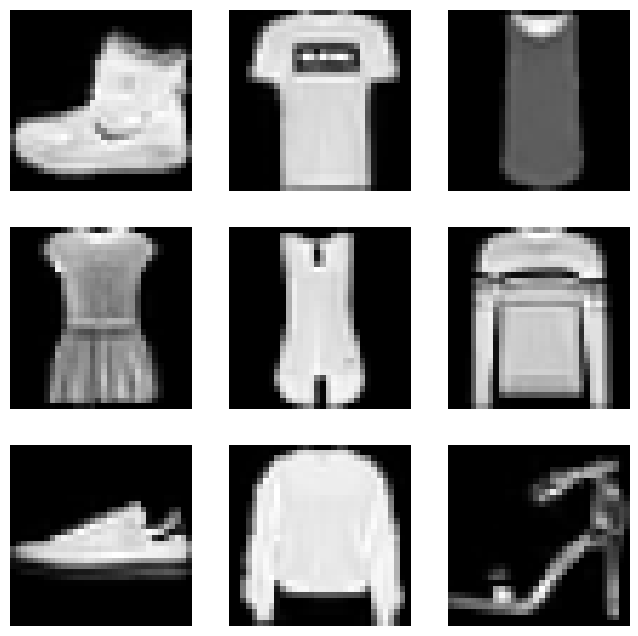

In [8]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [9]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [10]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [11]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
│    └─Unflatten: 2-9                    --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [12]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       524,800
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       131,328
│    └─LeakyReLU: 2-5                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [13]:
def noise_generator(batch_size: int) -> Generator[torch.Tensor, None, None]:
    while True:
        yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [14]:
EPOCH = 30

In [15]:
trainer = GANTrainer(EPOCH, DEVICE)

In [16]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [17]:
LR = 1e-4
BETA = (0.5, 0.999)

In [18]:
criterion_g = GANGeneratorLoss()
criterion_d = GANDiscriminatorLoss()
optim_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [19]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_g,
    optim_d,
    criterion_g,
    criterion_d,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:24<00:00, 19.07it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 6.7490e-03 (0.00%)
generator: 8.2977e-03 (0.00%)


100%|██████████| 468/468 [00:24<00:00, 18.72it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 1.1361e-02 (68.00%)
generator: 2.7032e-02 (226.00%)


100%|██████████| 468/468 [00:22<00:00, 20.83it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 1.6224e-02 (43.00%)
generator: 4.5693e-02 (69.00%)


100%|██████████| 468/468 [00:25<00:00, 18.71it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 2.1832e-02 (35.00%)
generator: 6.3768e-02 (40.00%)


100%|██████████| 468/468 [00:23<00:00, 19.58it/s]


------------------------------------
Epoch 5
------------------------------------
discriminator: 2.7801e-02 (27.00%)
generator: 8.0831e-02 (27.00%)


100%|██████████| 468/468 [00:24<00:00, 19.26it/s]


------------------------------------
Epoch 6
------------------------------------
discriminator: 3.4356e-02 (24.00%)
generator: 9.5282e-02 (18.00%)


100%|██████████| 468/468 [00:24<00:00, 18.85it/s]


------------------------------------
Epoch 7
------------------------------------
discriminator: 4.2265e-02 (23.00%)
generator: 1.0742e-01 (13.00%)


100%|██████████| 468/468 [00:24<00:00, 19.12it/s]


------------------------------------
Epoch 8
------------------------------------
discriminator: 5.0300e-02 (19.00%)
generator: 1.1874e-01 (11.00%)


100%|██████████| 468/468 [00:24<00:00, 19.19it/s]


------------------------------------
Epoch 9
------------------------------------
discriminator: 5.8554e-02 (16.00%)
generator: 1.2994e-01 (9.00%)


100%|██████████| 468/468 [00:24<00:00, 19.48it/s]


------------------------------------
Epoch 10
------------------------------------
discriminator: 6.6915e-02 (14.00%)
generator: 1.4083e-01 (8.00%)


100%|██████████| 468/468 [00:24<00:00, 18.86it/s]


------------------------------------
Epoch 11
------------------------------------
discriminator: 7.5375e-02 (13.00%)
generator: 1.5150e-01 (8.00%)


100%|██████████| 468/468 [00:23<00:00, 19.98it/s]


------------------------------------
Epoch 12
------------------------------------
discriminator: 8.4315e-02 (12.00%)
generator: 1.6130e-01 (6.00%)


100%|██████████| 468/468 [00:24<00:00, 18.87it/s]


------------------------------------
Epoch 13
------------------------------------
discriminator: 9.3296e-02 (11.00%)
generator: 1.7073e-01 (6.00%)


100%|██████████| 468/468 [00:24<00:00, 19.13it/s]


------------------------------------
Epoch 14
------------------------------------
discriminator: 1.0233e-01 (10.00%)
generator: 1.7996e-01 (5.00%)


100%|██████████| 468/468 [00:24<00:00, 19.10it/s]


------------------------------------
Epoch 15
------------------------------------
discriminator: 1.1136e-01 (9.00%)
generator: 1.8914e-01 (5.00%)


100%|██████████| 468/468 [00:25<00:00, 18.52it/s]


------------------------------------
Epoch 16
------------------------------------
discriminator: 1.2054e-01 (8.00%)
generator: 1.9807e-01 (5.00%)


100%|██████████| 468/468 [00:24<00:00, 18.78it/s]


------------------------------------
Epoch 17
------------------------------------
discriminator: 1.2968e-01 (8.00%)
generator: 2.0702e-01 (5.00%)


100%|██████████| 468/468 [00:24<00:00, 18.86it/s]


------------------------------------
Epoch 18
------------------------------------
discriminator: 1.3895e-01 (7.00%)
generator: 2.1564e-01 (4.00%)


100%|██████████| 468/468 [00:24<00:00, 19.05it/s]


------------------------------------
Epoch 19
------------------------------------
discriminator: 1.4830e-01 (7.00%)
generator: 2.2403e-01 (4.00%)


100%|██████████| 468/468 [00:24<00:00, 19.25it/s]


------------------------------------
Epoch 20
------------------------------------
discriminator: 1.5779e-01 (6.00%)
generator: 2.3228e-01 (4.00%)


100%|██████████| 468/468 [00:24<00:00, 19.30it/s]


------------------------------------
Epoch 21
------------------------------------
discriminator: 1.6730e-01 (6.00%)
generator: 2.4042e-01 (4.00%)


100%|██████████| 468/468 [00:24<00:00, 18.81it/s]


------------------------------------
Epoch 22
------------------------------------
discriminator: 1.7688e-01 (6.00%)
generator: 2.4839e-01 (3.00%)


100%|██████████| 468/468 [00:24<00:00, 19.25it/s]


------------------------------------
Epoch 23
------------------------------------
discriminator: 1.8653e-01 (5.00%)
generator: 2.5628e-01 (3.00%)


100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


------------------------------------
Epoch 24
------------------------------------
discriminator: 1.9628e-01 (5.00%)
generator: 2.6391e-01 (3.00%)


100%|██████████| 468/468 [00:23<00:00, 20.09it/s]


------------------------------------
Epoch 25
------------------------------------
discriminator: 2.0603e-01 (5.00%)
generator: 2.7158e-01 (3.00%)


100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


------------------------------------
Epoch 26
------------------------------------
discriminator: 2.1581e-01 (5.00%)
generator: 2.7919e-01 (3.00%)


100%|██████████| 468/468 [00:23<00:00, 19.97it/s]


------------------------------------
Epoch 27
------------------------------------
discriminator: 2.2566e-01 (5.00%)
generator: 2.8669e-01 (3.00%)


100%|██████████| 468/468 [00:22<00:00, 20.99it/s]


------------------------------------
Epoch 28
------------------------------------
discriminator: 2.3549e-01 (4.00%)
generator: 2.9417e-01 (3.00%)


100%|██████████| 468/468 [00:21<00:00, 21.75it/s]


------------------------------------
Epoch 29
------------------------------------
discriminator: 2.4537e-01 (4.00%)
generator: 3.0172e-01 (3.00%)


100%|██████████| 468/468 [00:24<00:00, 19.00it/s]

------------------------------------
Epoch 30
------------------------------------
discriminator: 2.5521e-01 (4.00%)
generator: 3.0920e-01 (2.00%)


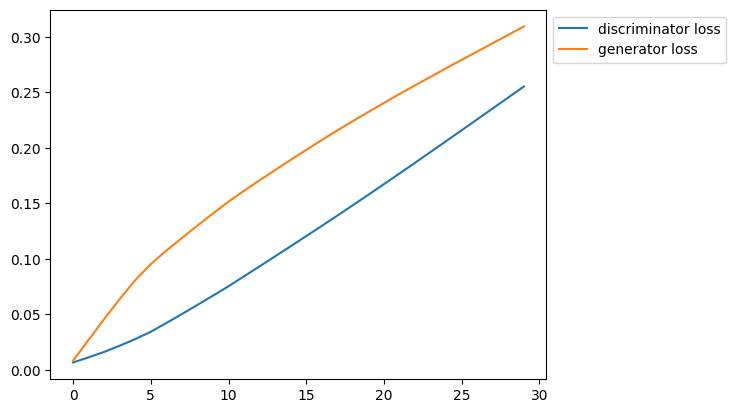

In [20]:
plt.plot(training_losses[0], label="discriminator loss")
plt.plot(training_losses[1], label="generator loss")
plt.legend(bbox_to_anchor=(1, 1))

# evaluation

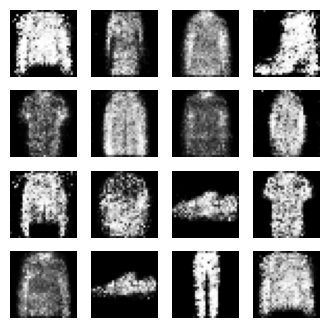

In [21]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [22]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:14<00:00, 31.21it/s]

0.68155


In [23]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:15<00:00, 30.75it/s]

0.47095


In [24]:
model_path = artifact_path / 'gan.pth'

In [25]:
torch.save(generator.state_dict(), model_path.as_posix())

In [26]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>